In [1]:
import h5py
import pandas as pd
import numpy as np

from data.processing import one_hot_encode, reverse_complement

from deepliftmotifs import Trainer
from motifs import DijkMotifs, FimoMotifs, StubMotifs
import numpy as np
import pandas as pd
from modisco.visualization import viz_sequence

from dijk import get_ordered_data_with_annotations
from collections import defaultdict as ddict
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
TF-MoDISco is using the TensorFlow backend.


In [2]:
pd.read_csv('./data/sharpr/sharprFullDataMatrix.tsv', delimiter='\t').iloc[:10].columns

Index(['name', 'chrom', 'center_coord', 'sequence', 'barcode',
       'chromatin_state', 'design', 'k562_minp_rep1_count',
       'k562_minp_rep2_count', 'k562_minp_avg_count', 'k562_sv40p_rep1_count',
       'k562_sv40p_rep2_count', 'k562_sv40p_avg_count',
       'hepg2_minp_rep1_count', 'hepg2_minp_rep2_count',
       'hepg2_minp_avg_count', 'hepg2_sv40p_rep1_count',
       'hepg2_sv40p_rep2_count', 'hepg2_sv40p_avg_count',
       'k562_minp_rep1_norm', 'k562_minp_rep2_norm', 'k562_minp_avg_norm',
       'k562_sv40p_rep1_norm', 'k562_sv40p_rep2_norm', 'k562_sv40p_avg_norm',
       'hepg2_minp_rep1_norm', 'hepg2_minp_rep2_norm', 'hepg2_minp_avg_norm',
       'hepg2_sv40p_rep1_norm', 'hepg2_sv40p_rep2_norm',
       'hepg2_sv40p_avg_norm', 'dna_minp_count', 'dna_sv40p_count'],
      dtype='object')

In [3]:
def get_sharpr_data(size=-1):
    ### rip memory
    data = pd.read_csv('./data/sharpr/sharprFullDataMatrix.tsv', delimiter='\t').iloc[:size]
    
    cols = ['hepg2_minp_avg_count', 'hepg2_sv40p_avg_count', 'hepg2_minp_avg_norm', 'hepg2_sv40p_avg_norm']
    # cols = [c for c in data.columns if 'hepg2' in c and 'avg' not in c]
    indices = [i for i, s in enumerate(data['sequence'].values) if 'N' not in s]
    X_reg = np.stack([one_hot_encode(s) for s in data['sequence'].iloc[indices].values])
    X_comp = np.stack([one_hot_encode(reverse_complement(s)) for s in data['sequence'].iloc[indices].values])
    X = np.zeros((X_reg.shape[0], 2, X_reg.shape[1], X_reg.shape[2]))
    X[:, 0, :, :] = X_reg
    X[:, 1, :, :] = X_comp
    
    Y = data[cols].iloc[indices].values
    return X, Y

In [6]:
x,y = get_sharpr_data(size=10000)

In [7]:
t = Trainer(StubMotifs(length=x.shape[0]), X=x, Y=y)

In [8]:
x.shape, y.shape

((10000, 2, 145, 4), (10000, 4))

In [10]:
seqmodel = t.trainFullSequence(epochs=1, input_shape=(145,4), output_shape=4)

Epoch 1/1
16000/16000 [==============================] - 10s 637us/step - loss: 29585.1753


In [11]:
scores, hypothetical_scores = t.getScores(seqmodel, sequence_length=145)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 1 the preceding linear layer is preact_1 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 2 the preceding linear layer is preact_2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is preact_3 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 4 the preceding linear layer is preact_4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is preact_

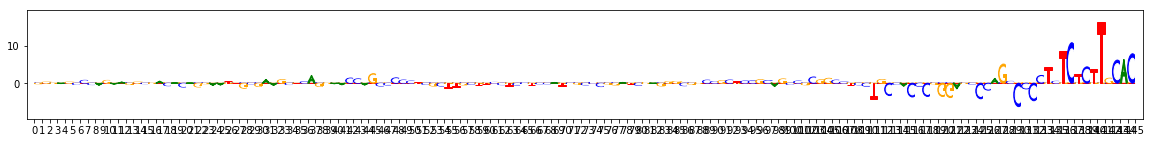

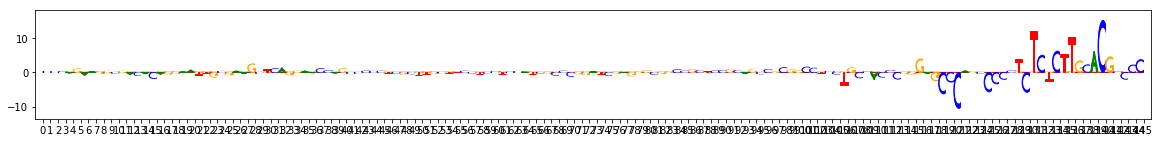

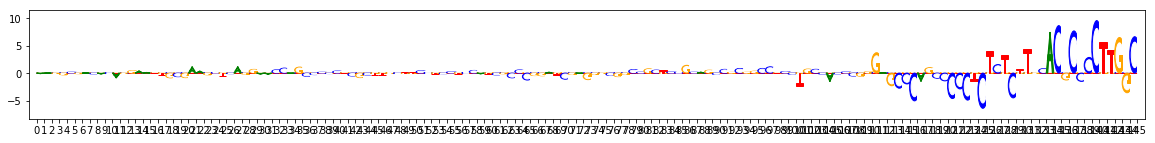

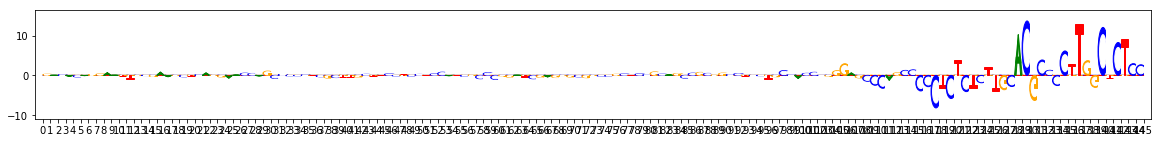

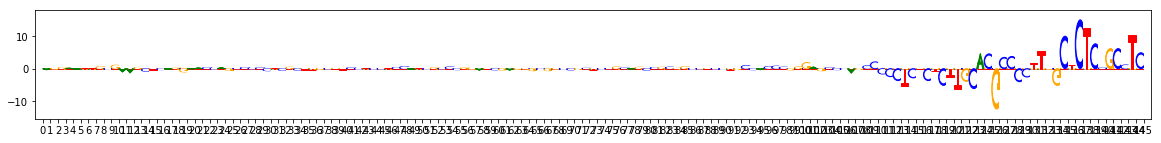

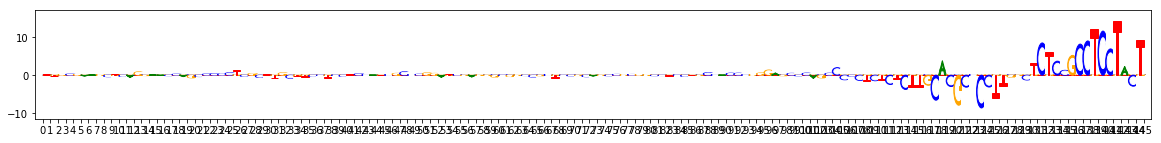

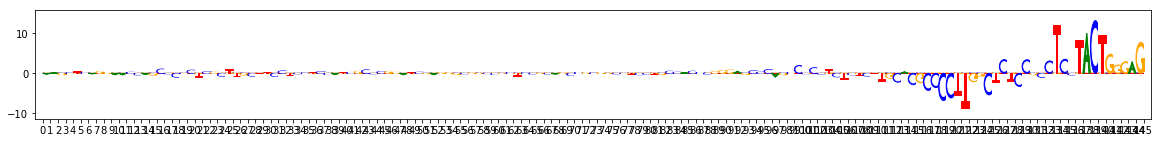

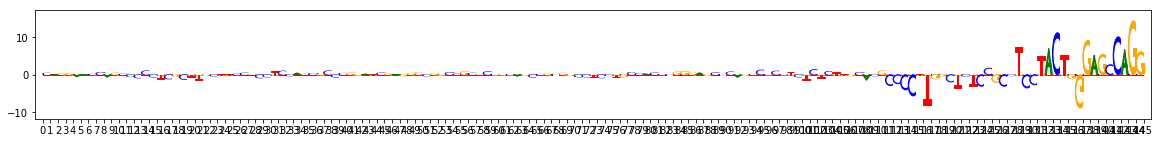

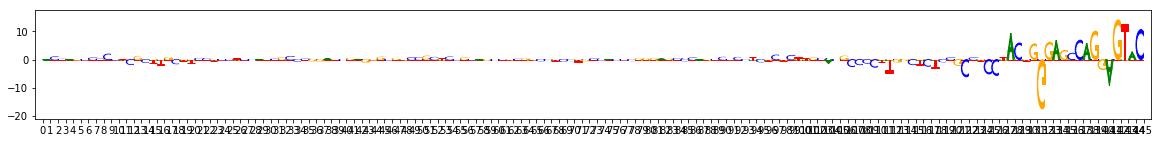

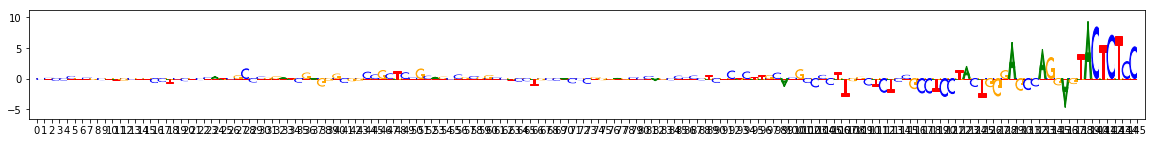

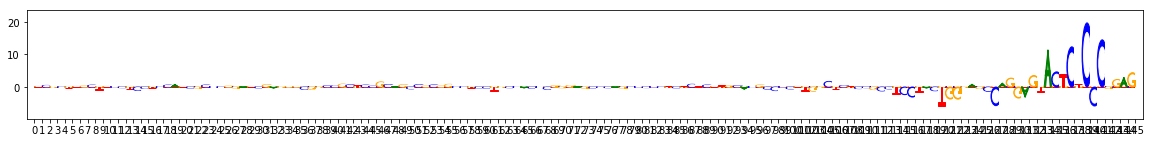

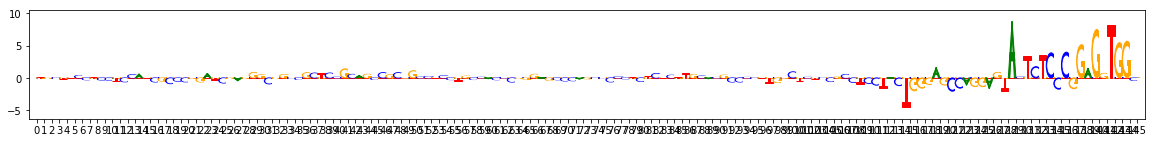

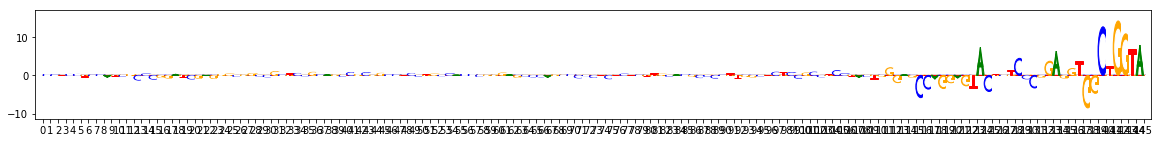

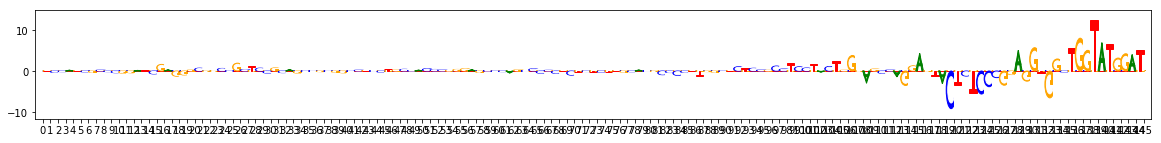

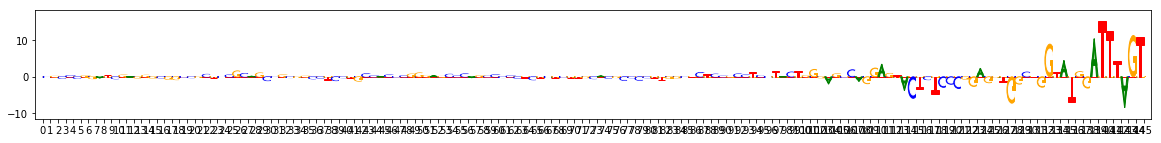

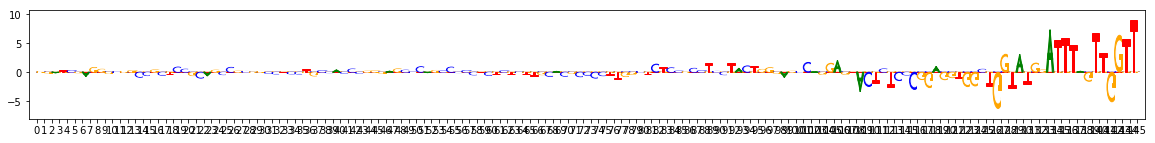

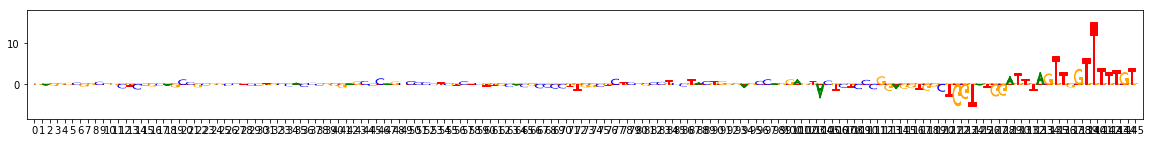

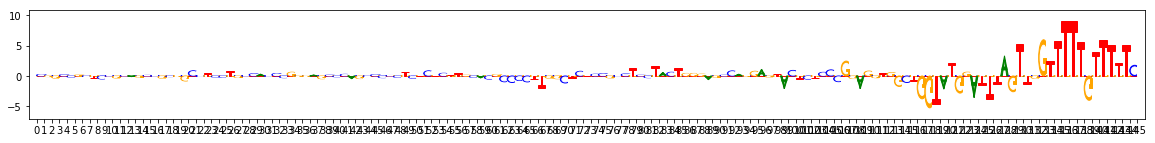

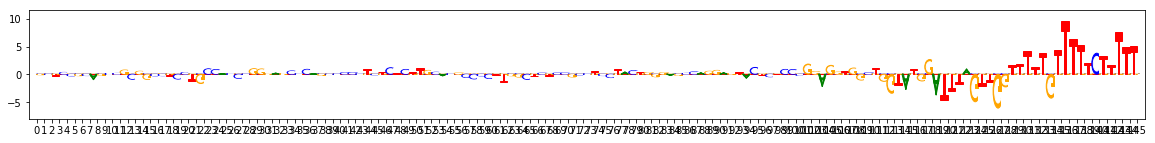

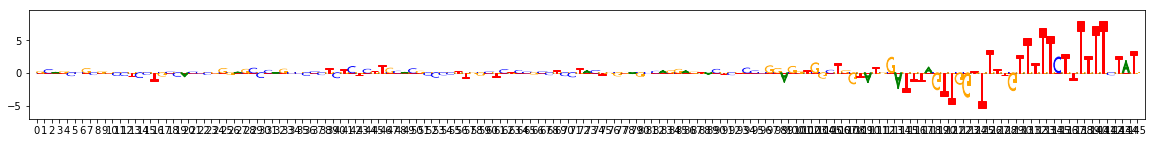

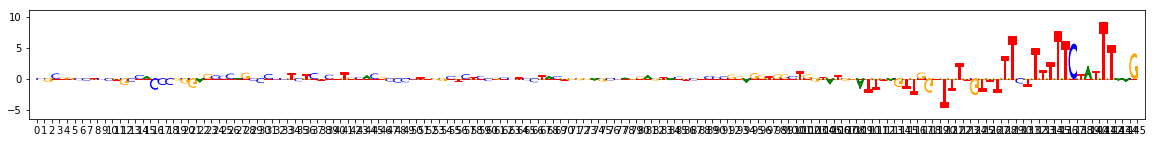

In [12]:
t.plotDeepLift(scores, num=20, verbose=True)

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= 0.7537347454428673
Computing threshold
Thresholds from null dist were -26.41348695755005  and  23.28176736831665
Final raw thresholds are -26.41348695755005  and  23.28176736831665
Final transformed thresholds are -0.91694  and  0.8981152


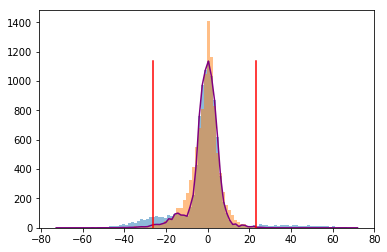

Got 7682 coords
After resolving overlaps, got 7682 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8981151
7682 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [7666]
Idx to activities:  {0: '-1'}
On metacluster 0
Metacluster size 7666
Relevant tasks:  ('task0',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 7666
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 19.51 s
Starting affinity matrix computations
Normalization computed in 1.69 s
Cosine similarity mat computed in 16.17 s
Normalization computed in 1.7 s
Cosine similarity mat computed in 17.55 s
Finished affinity matrix computations in 33.9 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 1.11 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculati

OSError: [Errno 12] Cannot allocate memory

In [13]:
tfmodisco = t.tfmodiscoResults(scores, hypothetical_scores)

In [ ]:
from collections import Counter
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt

import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
import h5py

!rm 'tfmodiscoresults.hdf5'
grp = h5py.File('tfmodiscoresults.hdf5')
tfmodisco.save_hdf5(grp)
hdf5_results = h5py.File('tfmodiscoresults.hdf5', 'r')

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

ids = set()

all_patterns = []
for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        #print(pattern["seqlets_and_alnmts"]["seqlets"].value)
        
        for s in pattern['seqlets_and_alnmts']['seqlets'].value:
            ids.add(int(s.decode().split(',')[0].split(':')[1]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
